## <font color = #990775> INSURANCE CROSS SELL</font>

### <font color=#990775>IMPORTS</font>

In [1]:
import math
import numpy               as np
import pandas              as pd
import seaborn             as sns
import scikitplot          as skplt
import plotly.express      as px
import matplotlib
import datetime
import inflection

from numpy                 import int64
from scipy                 import stats           as ss
from sklearn               import preprocessing   as pp
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import neighbors       as nh
from sklearn               import linear_model    as lm
from matplotlib            import pyplot          as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

### <font color = #990775>Helper Functions</font>

In [67]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def precision_at_k(data, k=2000):
    #reset_index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']


def recall_at_k (data, k=2000):
    #reset_index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### <font color = #990775>Loading Data</font>

In [3]:
data_raw = pd.read_csv('../data/train.csv')

In [4]:
df1 = data_raw.copy()

In [5]:
df1.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## <font color = #990775>DATA DESCRIPTION</font>

### <font color = #990775>Rename Columns</font>

In [6]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [7]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

### <font color = #990775>Data Dimensions</font>

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


### <font color = #990775>Data Types</font>

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### <font color = #990775>Check NA</font>

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### <font color = #990775>Change Data Types</font>

In [11]:
df1['id'] = df1['id'].astype(str)
df1['driving_license'] = df1['driving_license'].astype(str)
df1['previously_insured'] = df1['previously_insured'].astype(str)
df1['region_code'] = df1['region_code'].astype(str)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(str)
df1['response'] = df1['response'].astype(str)

In [12]:
df1.dtypes

id                       object
gender                   object
age                       int64
driving_license          object
region_code              object
previously_insured       object
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel     object
vintage                   int64
response                 object
dtype: object

### <font color = #990775>Descriptive Statistical</font>

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### <font color = #990775>Numerical Attributes</font>

In [14]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [15]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


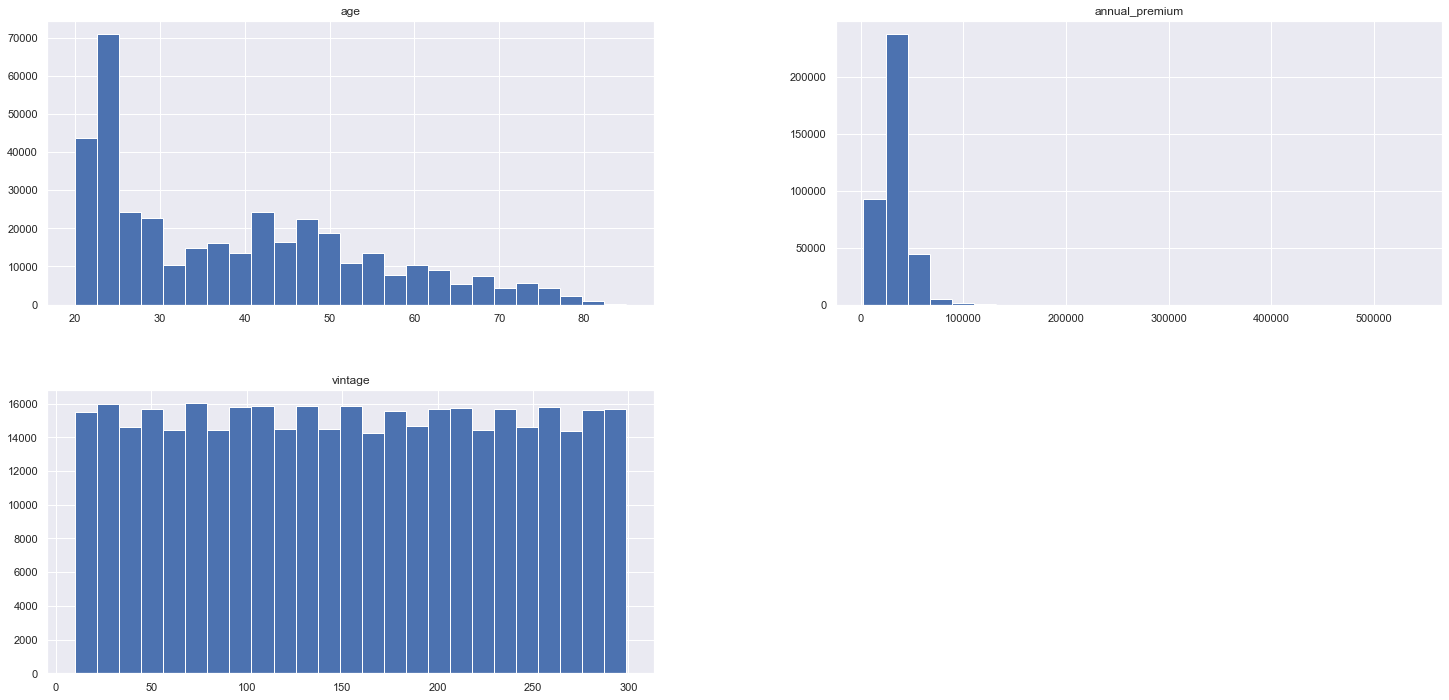

In [16]:
matplotlib.rcParams.update({'font.size': 5})
num_attributes.hist(bins = 25);

#### <font color = #990775>Categorical Attributes</font>

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                      381109
gender                       2
driving_license              2
region_code                 53
previously_insured           2
vehicle_age                  3
vehicle_damage               2
policy_sales_channel       155
response                     2
dtype: int64

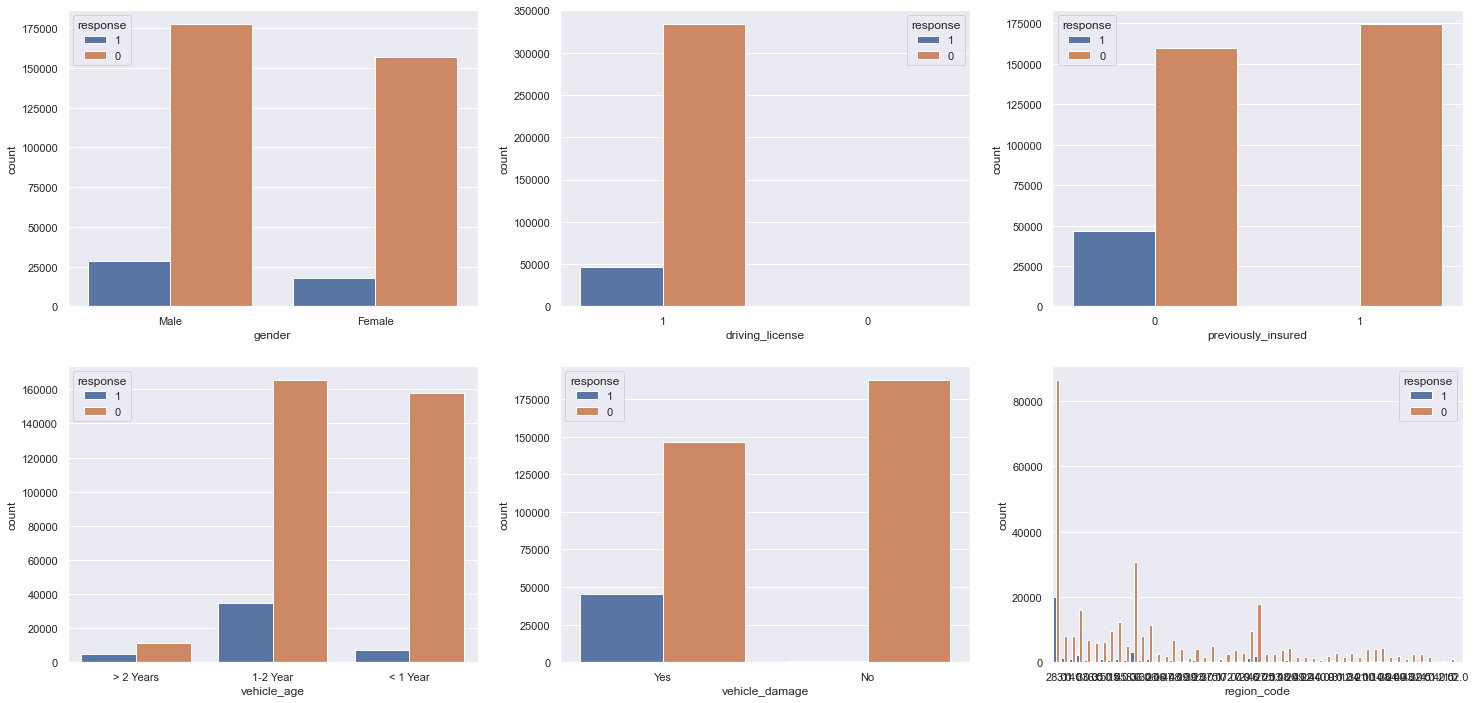

In [18]:
grid = GridSpec(2, 3)

# plt.subplot(1, 3, 1)
plt.subplot(grid[0, 0])
sns.countplot(data=df1, x='gender', hue='response');

plt.subplot(grid[0, 1])
sns.countplot(data=df1, x='driving_license', hue='response');

plt.subplot(grid[0, 2])
sns.countplot(data=df1, x='previously_insured', hue='response');

plt.subplot(grid[1, 0])
sns.countplot(data=df1, x='vehicle_age', hue='response');

plt.subplot(grid[1, 1])
sns.countplot(data=df1, x='vehicle_damage', hue='response');

plt.subplot(grid[1, 2])
sns.countplot(data=df1, x='region_code', hue='response');

In [19]:
df1.driving_license.value_counts()

1    380297
0       812
Name: driving_license, dtype: int64

## <font color = #990775>FEATURE ENGINEERING</font>

In [20]:
df2 = df1.copy()

### <font color = #990775>Mind Map Hypothesis</font>

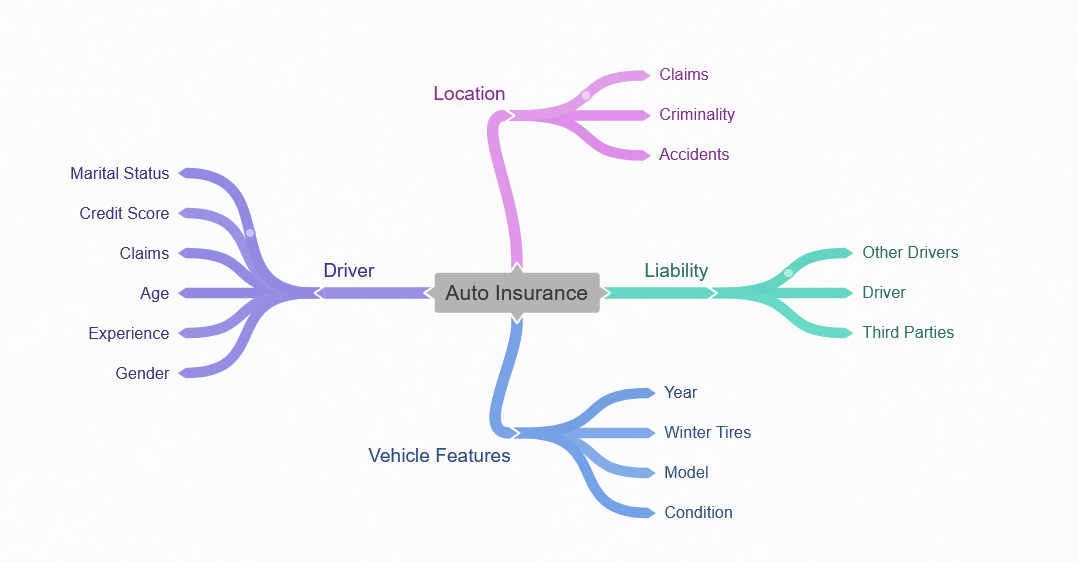

In [21]:
Image("../images/mind_map.png")

### <font color = #990775>Hypothesis Creation</font>

**-** Unlicensed clients would be less likely to purchase auto insurance

**-** Younger clients would be more likely to purchase auto insurance

**-** Female clients would be more likely to purchase auto insurance

**-** Clients who have already had their vehicle damaged would be more likely to purchase auto insurance

**-** Clients who have already been involved in any vehicle accident would be more likely to purchase auto insurance

**-** Clients who have already had their vehicle insured would be more likely to purchase auto insurance

**-** Clients for a longer time at the current brokerage would be more likely to purchase auto insurance

**-** Clients who pay more for health insurance would be more likely to purchase auto insurance

**-** Clients under some specific policy sales channels would be more likely to purchase auto insurance

**-** Clients living in some specific region codes would be more likely to purchase auto insurance

**-** Clients from locations with a high level of claims would be more likely to purchase auto insurance

**-** Clients with more than 2 drivers in the household would be more likely to purchase auto insurance

**-** Clients with older vehicles would be less likely to purchase auto insurance.

#### <font color = #990775>List of discarded hypothesis for not having enough data to be tested</font>

**-** Clients who have already been involved in any vehicle accident would be more likely to purchase auto insurance

**-** Clients with more than 2 drivers in the household would be more likely to purchase auto insurance

**-** Clients from locations with a high level of claims would be more likely to purchase auto insurance

#### <font color = #990775>List of hypothesis to be tested (validate or disproof)</font>

**1.** Unlicensed clients would be less likely to purchase auto insurance

**2.** Younger clients would be more likely to purchase auto insurance

**3.** Female clients would be more likely to purchase auto insurance

**4.** Clients who have already had their vehicle damaged would be more likely to purchase auto insurance

**5.** Clients who have already had their vehicle insured would be more likely to purchase auto insurance

**6.** Clients for a longer time at the current brokerage would be more likely to purchase auto insurance

**7.** Clients who pay more for health insurance would be more likely to purchase auto insurance

**8.** Clients under some specific policy sales channels would be more likely to purchase auto insurance

**9.** Clients living in some specific region codes would be more likely to purchase auto insurance

**10.** Clients with older vehicles would be less likely to purchase auto insurance.

### <font color = #990775>Feature Engineering</font>

In [22]:
df2 = df1.copy()

In [23]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x=='> 2 Years' else 'between_1_2_years' if x=='1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

In [24]:
df2.head(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


## <font color = #990775>FILTERING FEATURES</font>

Per the descriptive statistics analysis and the business assumptions, no features were considered to be filtered out (no data to be excluded).

## <font color = #990775>EXPLORATORY DATA ANALYSIS (EDA)</font>

In [25]:
df3 = df2.copy()

### <font color = #990775>Univariate Analysis</font>

#### <font color = #990775>Response Variable</font>

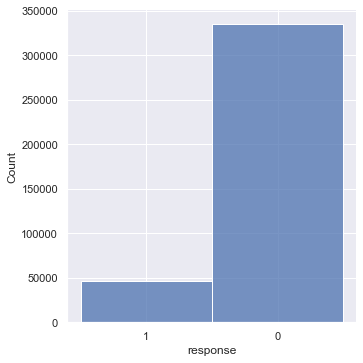

In [26]:
sns.displot(df3['response'])

The chart above shows that data is unbalanced in the dataset. For the first round of the data analysis, lets simply watch the variables as they are actually presented.

#### <font color = #990775>Numerical Predictor Variables</font>

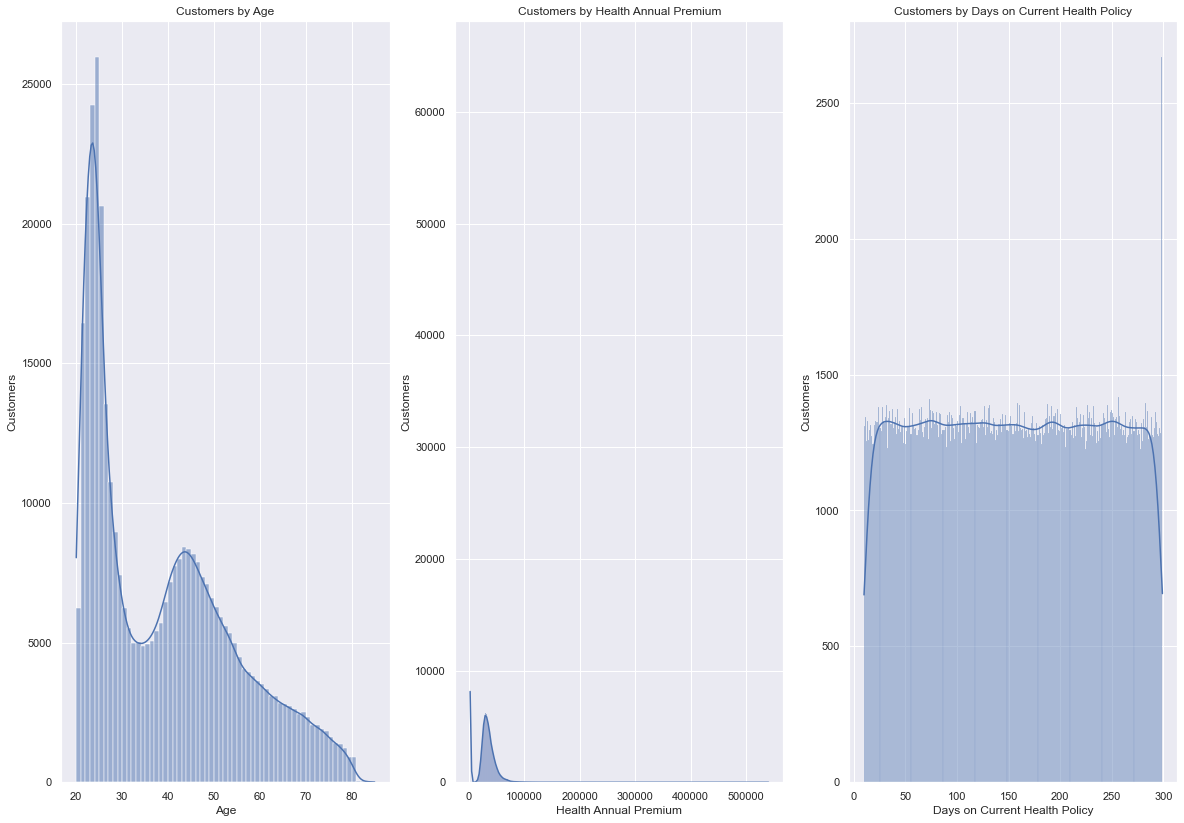

In [27]:
plt.figure(figsize=(20,14))

plt.subplot(1,3,1)
age_hist = sns.histplot(df3['age'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(1,3,2)
hap_hist = sns.histplot(df3['annual_premium'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Premium')
hap_hist.set_title('Customers by Health Annual Premium');

plt.subplot(1,3,3)
da_hist = sns.histplot(df3['vintage'], binwidth=1, kde=True);
da_hist.set_ylabel('Customers')
da_hist.set_xlabel('Days on Current Health Policy')
da_hist.set_title('Customers by Days on Current Health Policy');

#### <font color = #990775>Categorical Predictor Variables</font>

In [28]:
#Considering that no features were filtered out, the charts for numerical and predictor variables would be the same 
#as shown in the "Descriptive Analysis" section above.

### <font color = #990775>Bivariate Analysis and Hypotheses Testing</font>

#### <font color = #990775>Hypothesis 1 - Unlicensed clients would be less likely to purchase auto insurance</font>

**TRUE:** Actually, UNLICENSED clients purchase LESS auto insurance

In [29]:
# driving_license

# changing types to numerical to visualize in some other charts
df3['driving_license'] = df3['driving_license'].astype(int64)

aux = df3[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = round(aux['driving_license'] / aux['driving_license'].sum(), 2)
aux.head()
# it shows clients that have driving license (sum of 1's) for each response
# 88% of licensed clientes doesn't want to get a (new) automobile policy

,response,driving_license,driving_license_perc
0,0,333628,0.88
1,1,46669,0.12


<AxesSubplot:xlabel='response', ylabel='driving_license'>

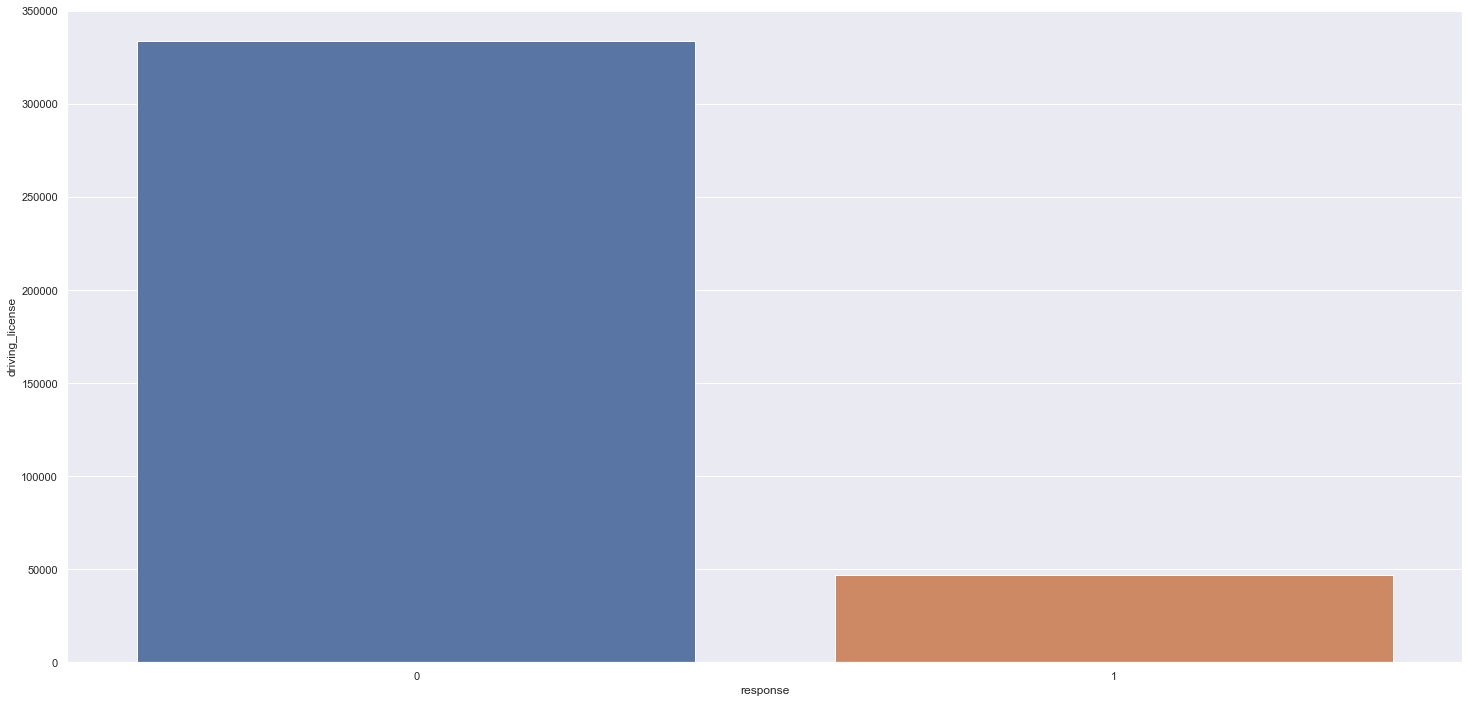

In [30]:
sns.barplot(x='response', y='driving_license', data=aux)

In [31]:
my_crosstab = pd.crosstab(index=df3['response'], columns=df3['driving_license'], margins=True)
my_crosstab

driving_license,0,1,All
response,,,
0,771,333628,334399
1,41,46669,46710
All,812,380297,381109


#### <font color = #990775>Hypothesis 2 - Younger clients would be more likely to purchase auto insurance</font>

**TRUE:** Actually, YOUNGER clients purchase MORE auto insurance

<AxesSubplot:xlabel='response', ylabel='age'>

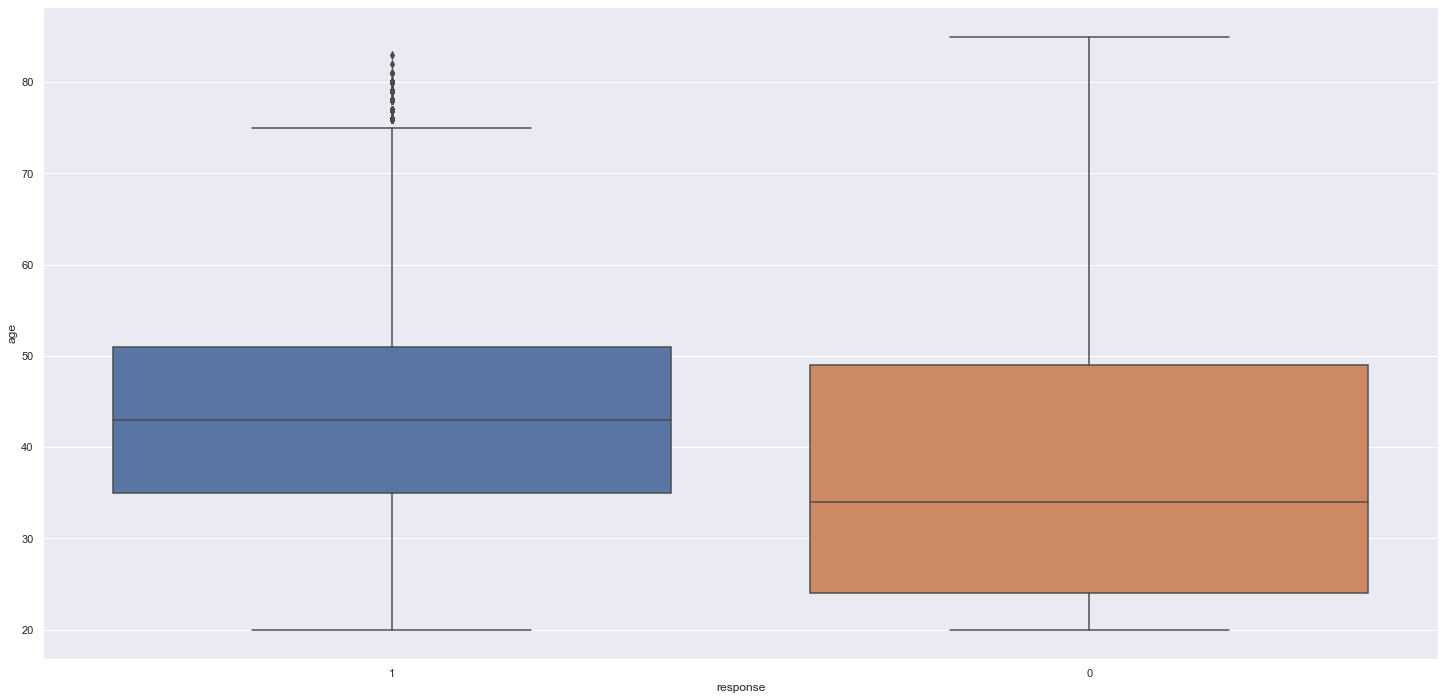

In [32]:
# age
sns.set(rc={'figure.figsize':(25, 12)})
sns.boxplot(x='response', y='age', data=df3)

Comparing the median in both boxplots we would consider 'age' as an important feature for the modelling,
since the customers that replied 'yes' are around 45 years old while the median for 'no' is around 35. 
Now, considering that age is a continuous variable, lets analyse it in another format (histogram):

<AxesSubplot:xlabel='age', ylabel='Count'>

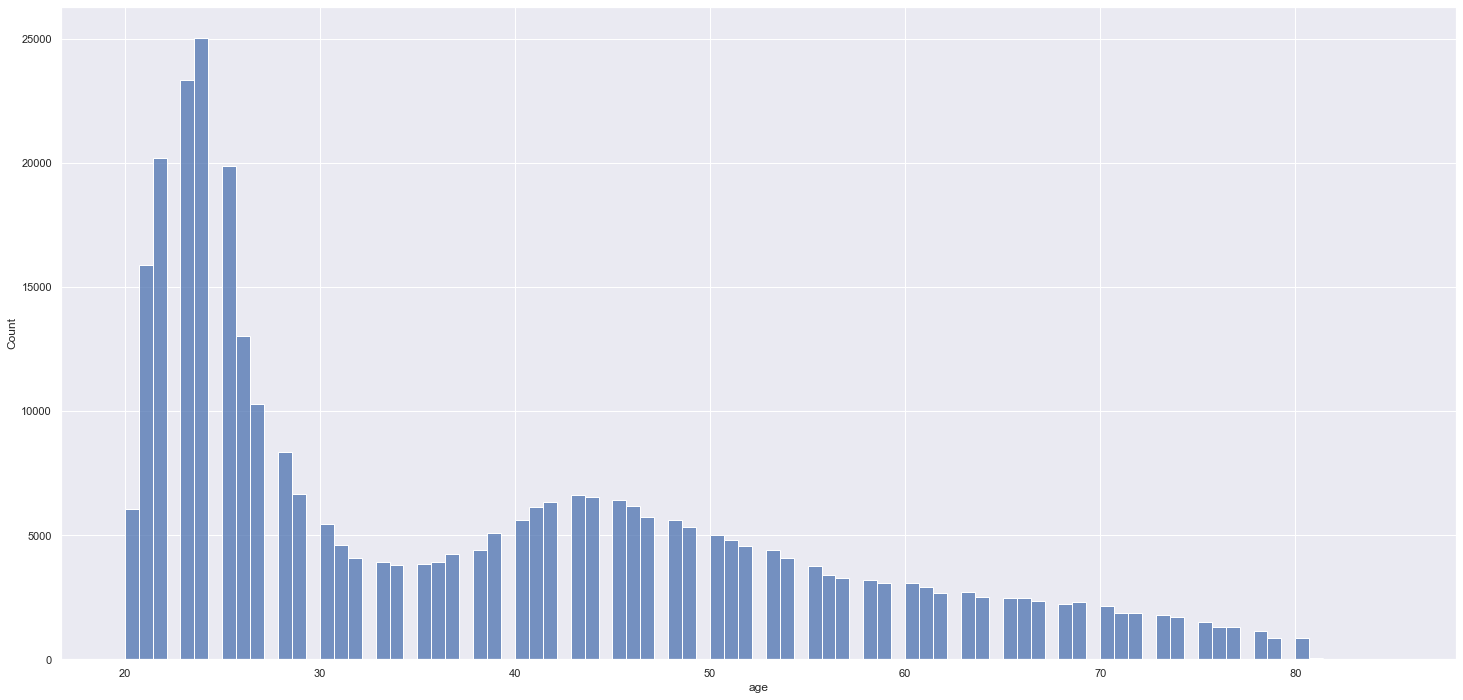

In [33]:
df3['response'] = df3['response'].astype(int64)
aux00 = df3.loc[df3['response'] == 0, 'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

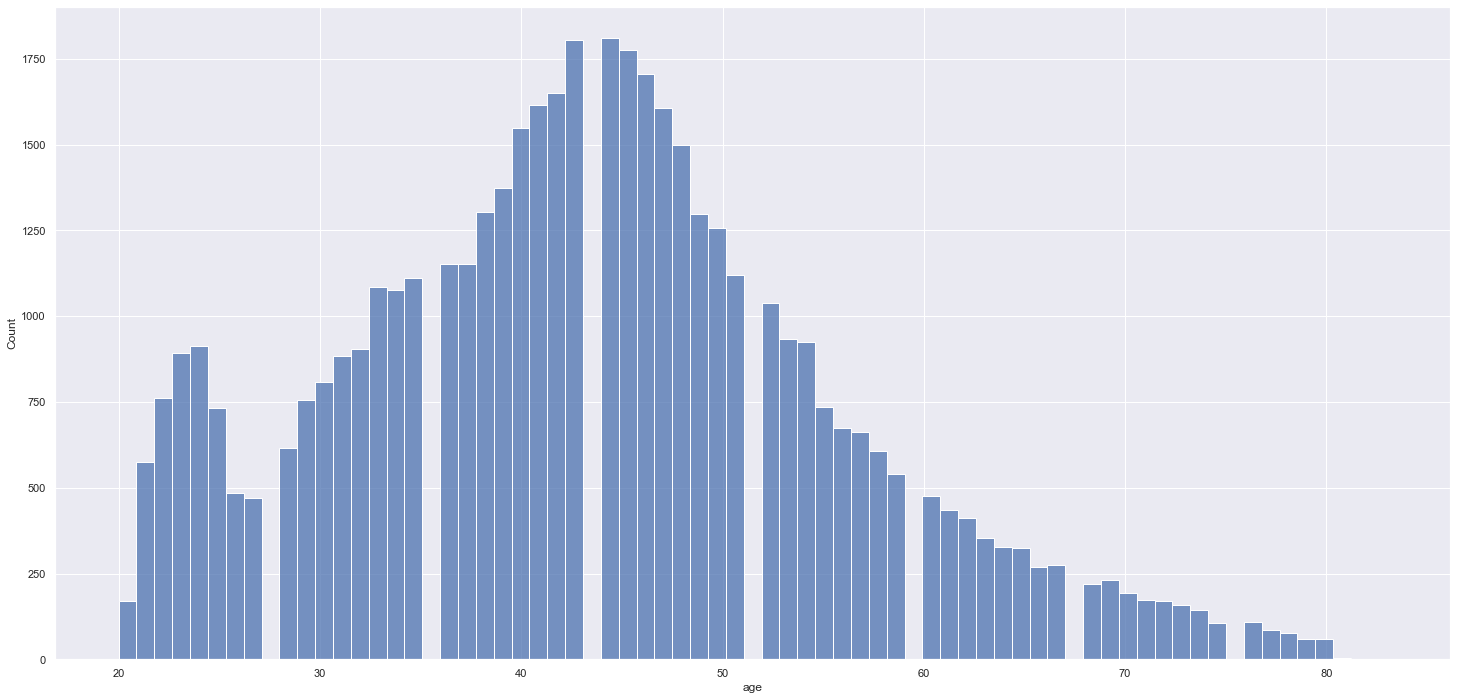

In [34]:
aux00 = df3.loc[df3['response'] == 1, 'age']
sns.histplot(aux00)

#### <font color = #990775>Hypothesis 3 - Female clients would be more likely to purchase auto insurance</font>

**FALSE:** Actually, MALE clients purchase MORE auto insurance

In [35]:
# gender
df3[['gender', 'response']].value_counts(normalize=True).reset_index().sort_values('gender', ascending=True)

,gender,response,0
1,Female,0,0.411523
3,Female,1,0.047716
0,Male,0,0.465914
2,Male,1,0.074847


#### <font color = #990775>Hypothesis 4 - Clients who have already had their vehicle damaged would be more likely to purchase auto insurance</font>

**FALSE:** Actually, clients with VEHICLE DAMAGED IN THE PAST purchase LESS auto insurance

In [36]:
# vehicle_damage

# changing types to numerical to visualize in some other charts
df3['vehicle_damage'] = df3['vehicle_damage'].astype(int64)

aux = df3[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
aux['vehicle_damage_perc'] = round(aux['vehicle_damage'] / aux['vehicle_damage'].sum(), 2)
aux.head()
# it shows clients that already had their vehicle damaged (sum of 1's) for each response
# 76% of such clientes doesn't want to get a (new) automobile policy

,response,vehicle_damage,vehicle_damage_perc
0,0,146685,0.76
1,1,45728,0.24


<AxesSubplot:xlabel='response', ylabel='vehicle_damage'>

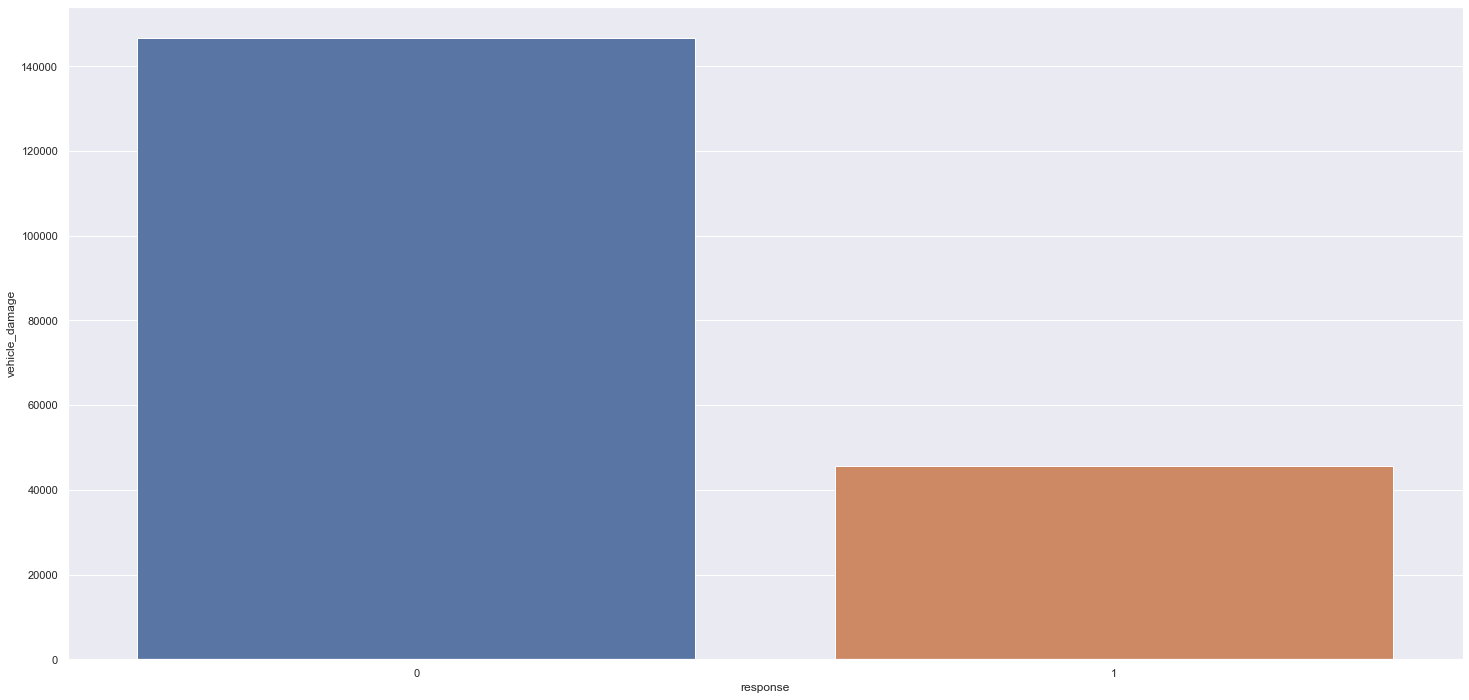

In [37]:
sns.barplot(x='response', y='vehicle_damage', data=aux)

In [38]:
my_crosstab = pd.crosstab(index=df3['response'], columns=df3['vehicle_damage'], margins=True)
my_crosstab

vehicle_damage,0,1,All
response,,,
0,187714,146685,334399
1,982,45728,46710
All,188696,192413,381109


#### <font color = #990775>Hypothesis 5 - Clients who have already had their vehicle insured would be more likely to purchase auto insurance</font>

**FALSE:** Actually, PREVIOUSLY INSURED clients purchase LESS auto insurance.

The assumption here is that client is currently insured under other carrier and/or is not interested in changing the brokerage.

In [39]:
# previously_insured
pd.crosstab(df3['previously_insured'], df3['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


#### <font color = #990775>Hypothesis 6 - Clients for a longer time at the current brokerage would be more likely to purchase auto insurance</font>

**FALSE:** Actually, CURRENT HEALTH INSURANCE clients are just as likely to purchase auto insurance.

The dataset considered only the time at the current one-year health insurance term, so the days go from 1 to 365.
For the next cicles of CRISP, real vintage time should be considered (in years).

<AxesSubplot:xlabel='response', ylabel='vintage'>

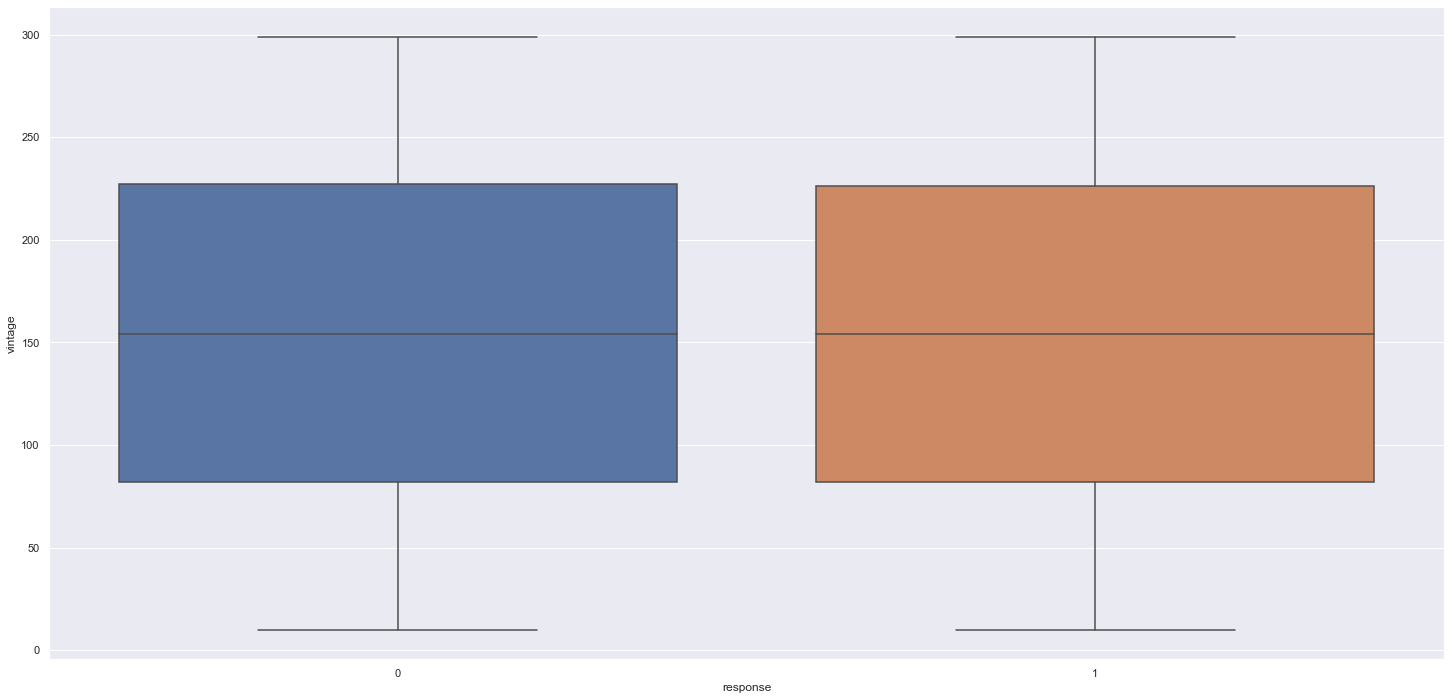

In [40]:
# vintage
sns.boxplot(x='response', y='vintage', data=df3)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

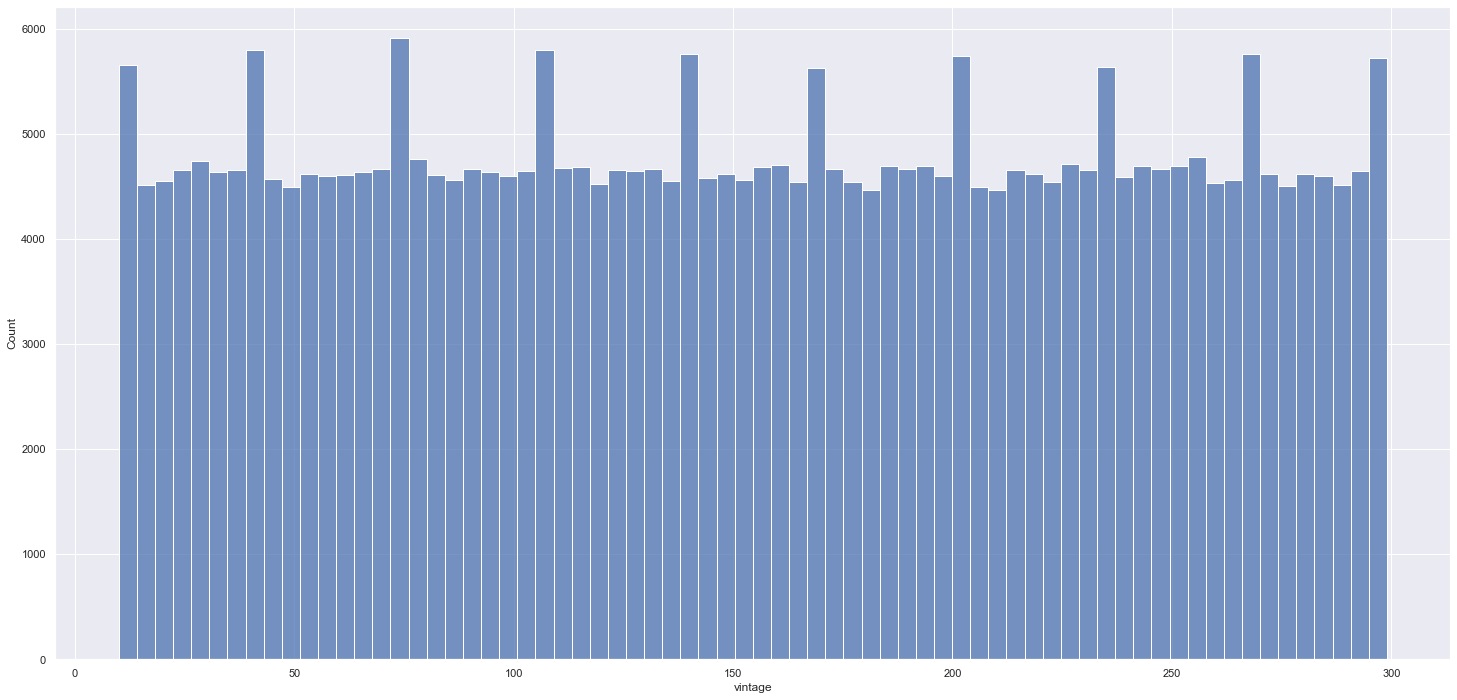

In [41]:
aux00 = df3.loc[df3['response']==0, 'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

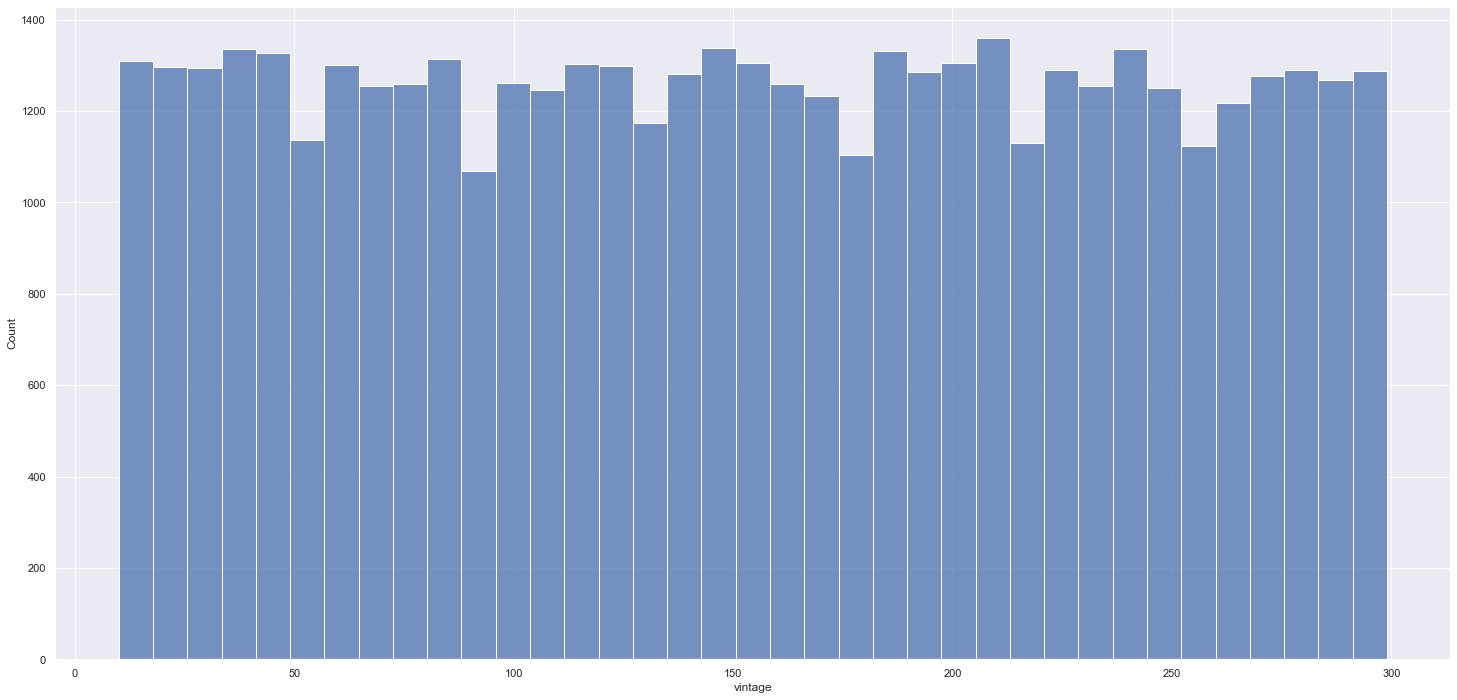

In [42]:
aux00 = df3.loc[df3['response']==1, 'vintage']
sns.histplot(aux00)

#### <font color = #990775>Hypothesis 7 - Clients who pay more for health insurance would be more likely to purchase auto insurance</font>

**FALSE:** Actually, ANNUAL PREMIUM FOR HEALTH INSURANCE doesn't have any clear impact at the decision to purchase auto insurance. Despite of data being unbalanced, there is no clear difference between the two outputs.

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

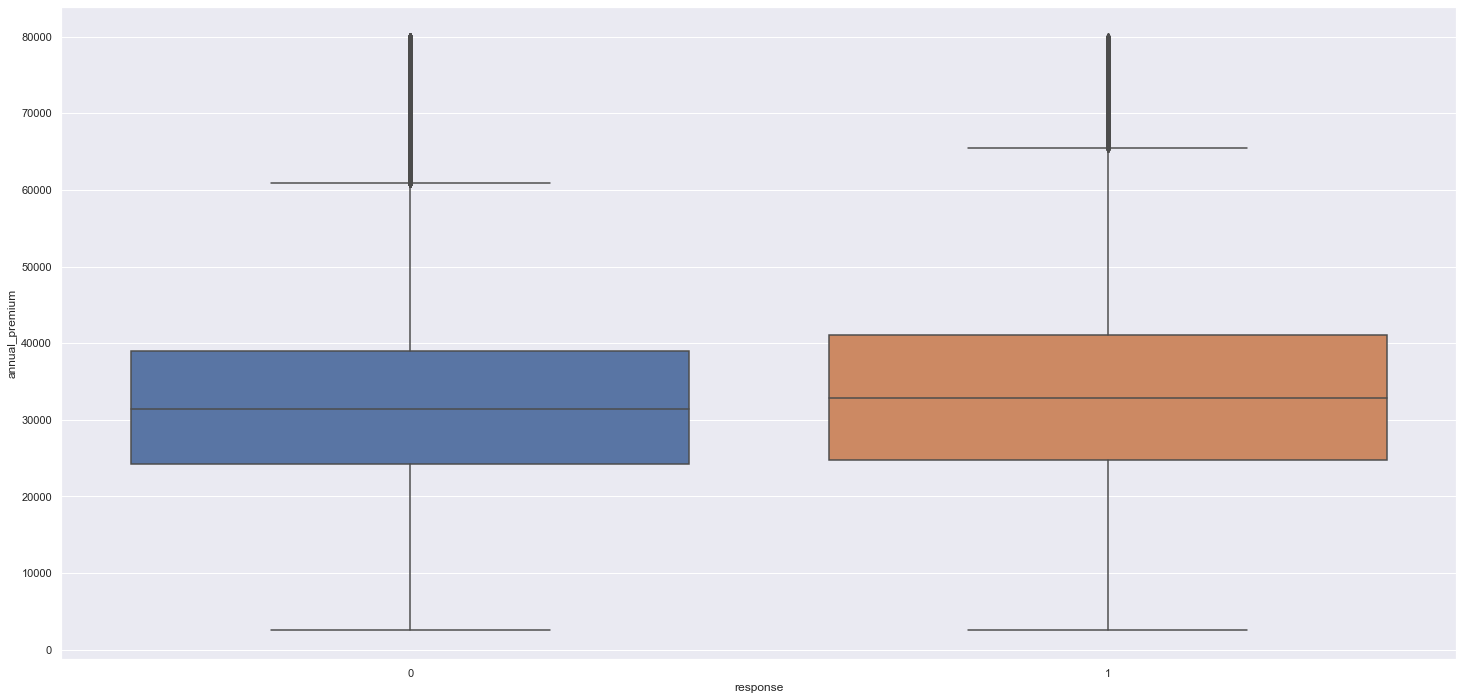

In [43]:
# annual_premium

# zoom in to better visualize
aux = df3[df3['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

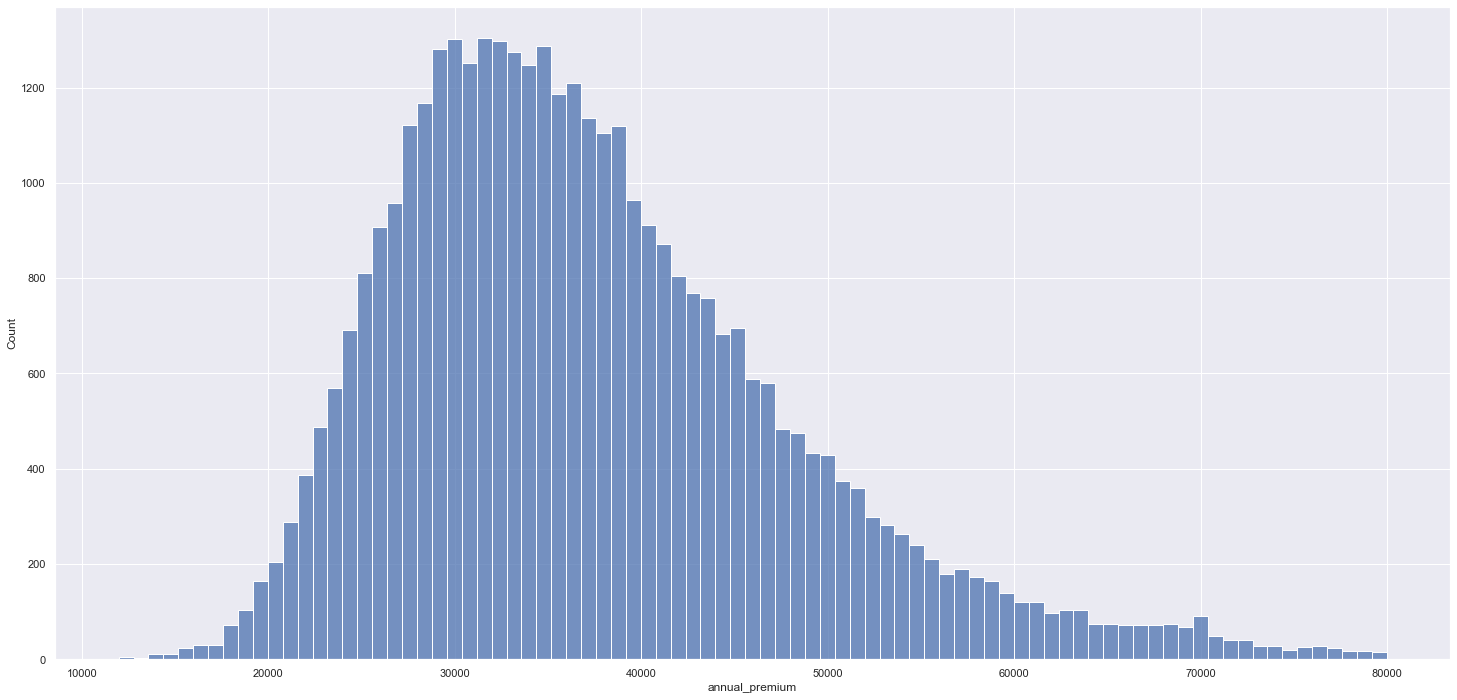

In [44]:
aux = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

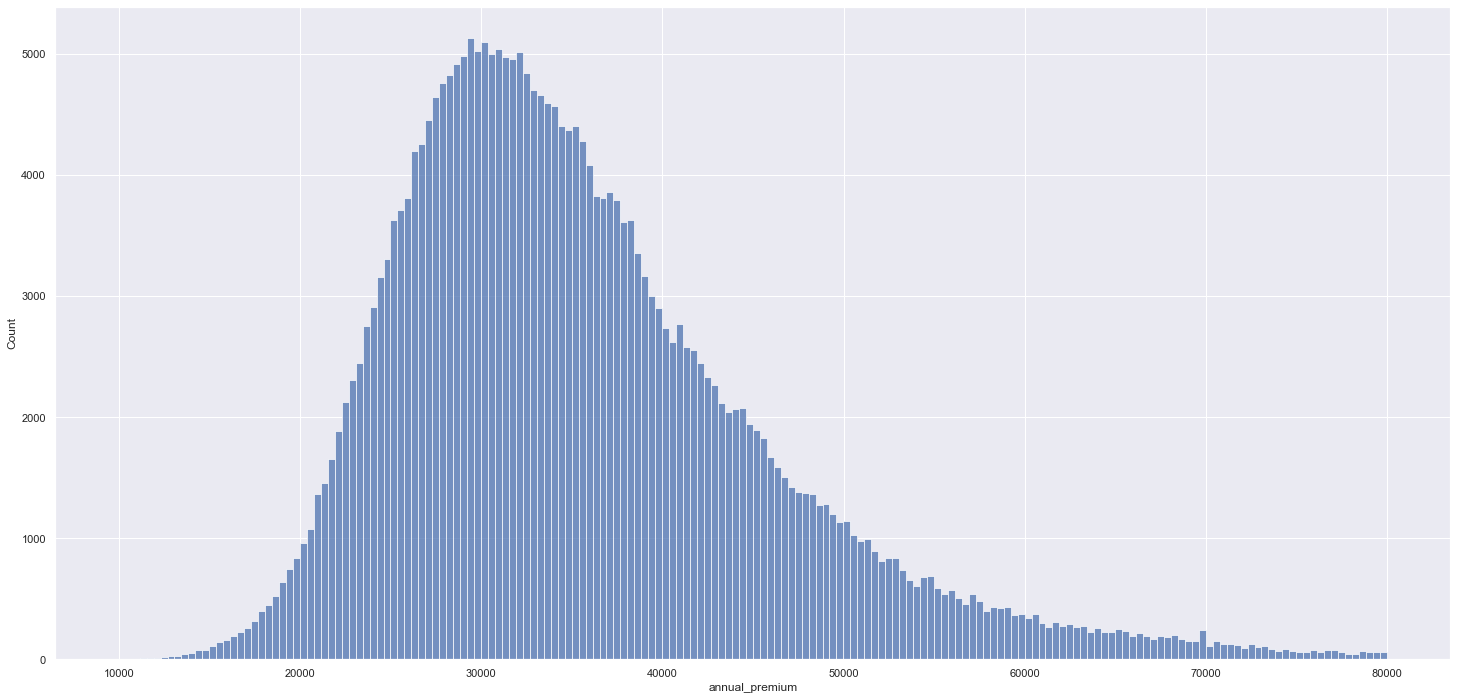

In [45]:
aux = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

#### <font color = #990775>Hypothesis 8 - Clients under some specific policy sales channels would be more likely to purchase auto insurance</font>

**FALSE:** Actually, the different 155 POLICY SALES CHANNELS look just as likely to influence the purchase of auto insurance.

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

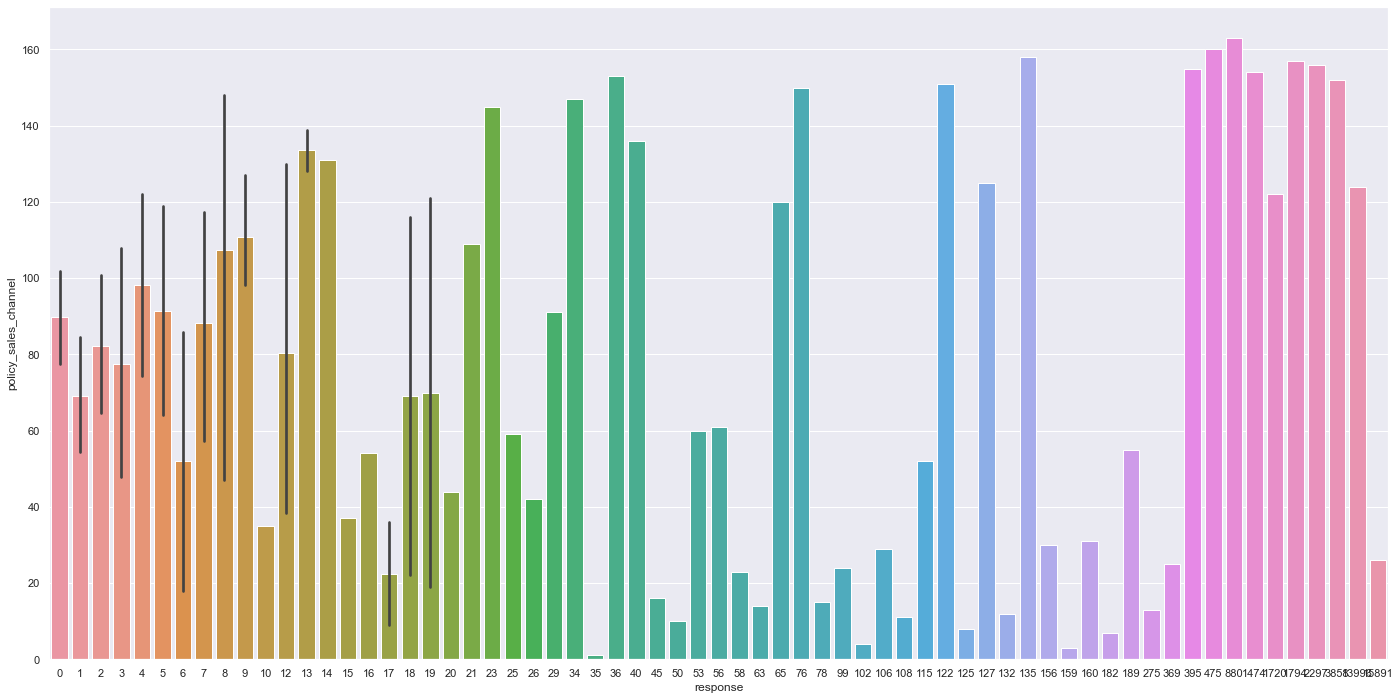

In [46]:
# policy sales channel
df3['policy_sales_channel'] = df3['policy_sales_channel'].astype(float64)
plt.figure(figsize=(24, 12))
aux = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)

In [47]:
# change back to categorical type
df3['policy_sales_channel'] = df3['policy_sales_channel'].astype(str)

#### <font color = #990775>Hypothesis 9 - Clients living in some specific region codes would be more likely to purchase auto insurance.</font>

**FALSE:** Actually, the different 53 REGION CODES look just as likely to influence the purchase of auto insurance.

<AxesSubplot:xlabel='region_code', ylabel='id'>

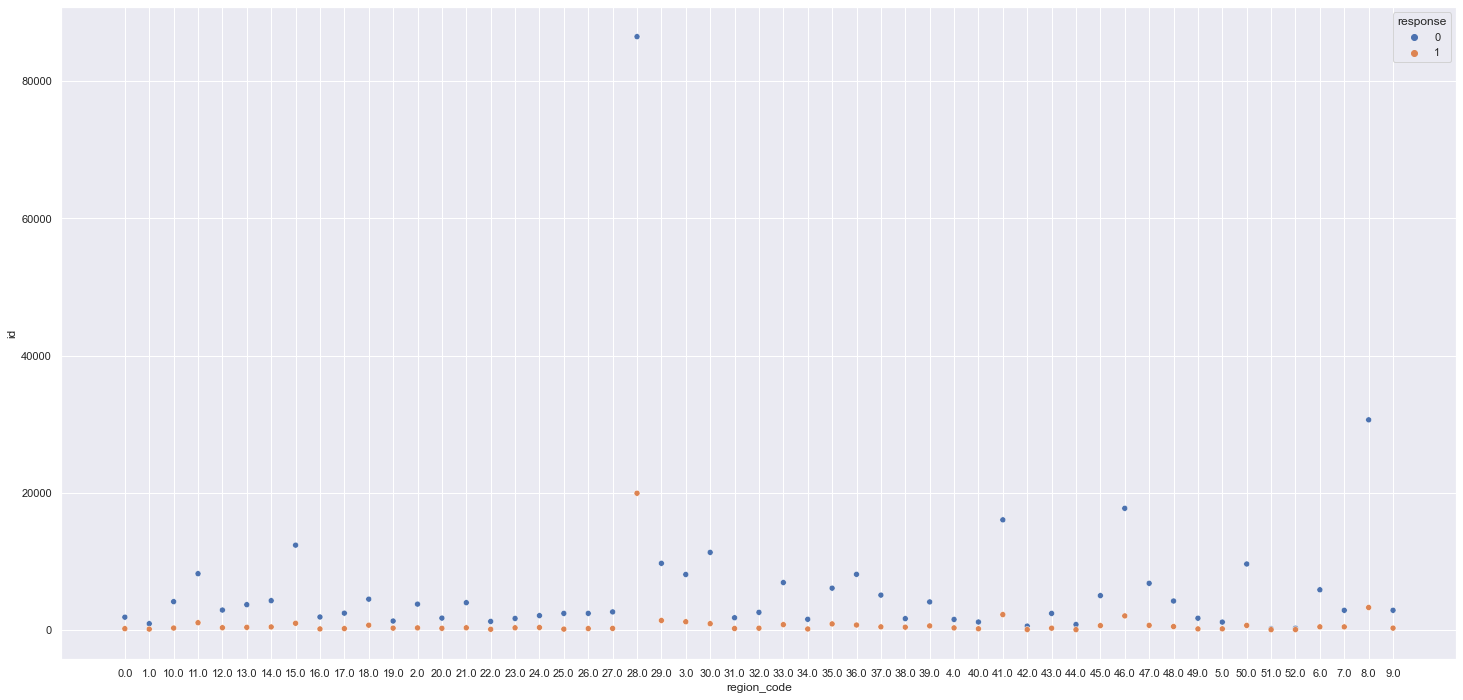

In [48]:
# region_code
aux0 = df3[['id','region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

#### <font color = #990775>Hypothesis 10 - Clients with older vehicles would be less likely to purchase auto insurance.</font>

**TRUE:** Clients with OLDER VEHICLES purchase LESS auto insurance.

In [49]:
pd.crosstab(df3['vehicle_age'], df3['response']).apply(lambda x: x/x.sum(), axis=1).sort_values('vehicle_age', ascending=True)

response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1_2_years,0.826245,0.173755
over_2_years,0.706254,0.293746


#### <font color = #990775>Hypotheses Summary</font>

In [50]:
tab = [['HIPOTHESIS', 'CONCLUSION', 'RELEVANCE'],

       ['H1', 'True', 'High'],
       ['H2', 'True', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'High'],
       ['H5', 'False', 'High'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Low'],
       ['H8', 'False', 'Low'],
       ['H9', 'False', 'Low'],
       ['H10', 'True', 'High'],

]
print(tabulate(tab, headers='firstrow'))

HIPOTHESIS    CONCLUSION    RELEVANCE
------------  ------------  -----------
H1            True          High
H2            True          Medium
H3            False         Medium
H4            False         High
H5            False         High
H6            False         Low
H7            False         Low
H8            False         Low
H9            False         Low
H10           True          High


### <font color = #990775>Multivariate Analysis</font>

In [51]:
num_attributes = df3.select_dtypes(include=['int64', 'float64'])
cat_attributes = df3.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### <font color = #990775>Numerical Attributes</font>

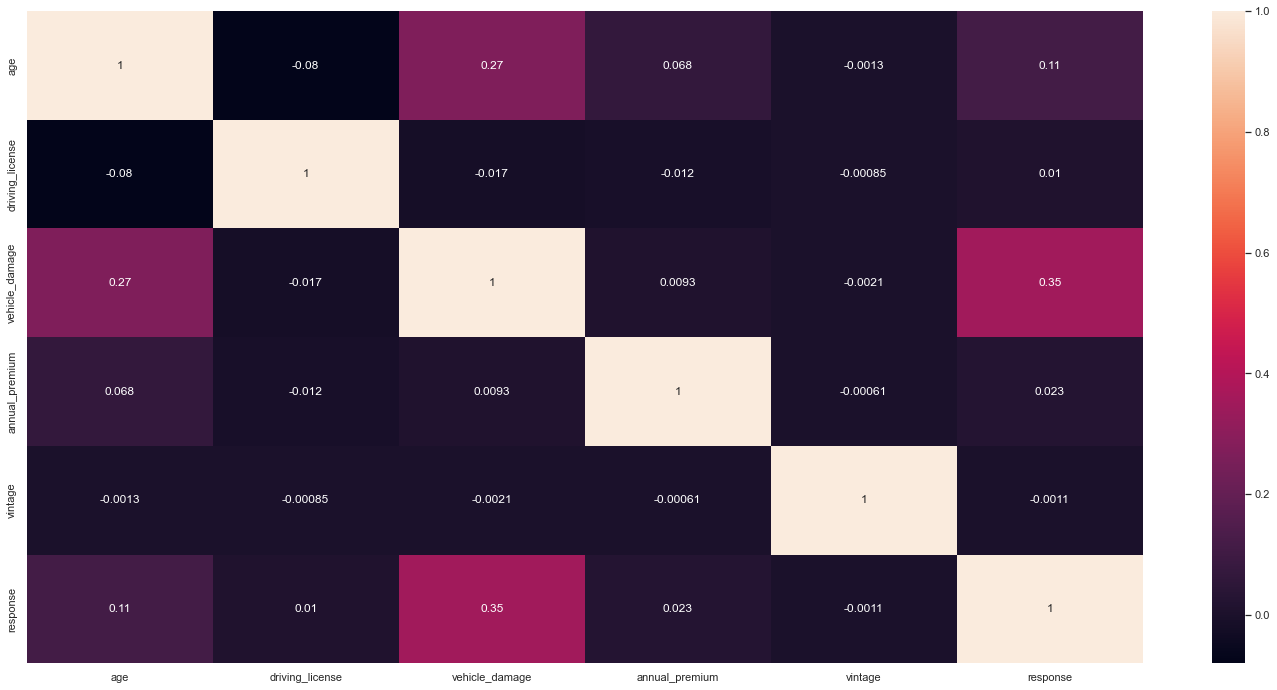

In [52]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### <font color = #990775>Categorical Attributes</font>

In [53]:
df3.dtypes

id                       object
gender                   object
age                       int64
driving_license           int64
region_code              object
previously_insured       object
vehicle_age              object
vehicle_damage            int64
annual_premium          float64
policy_sales_channel     object
vintage                   int64
response                  int64
dtype: object

<AxesSubplot:>

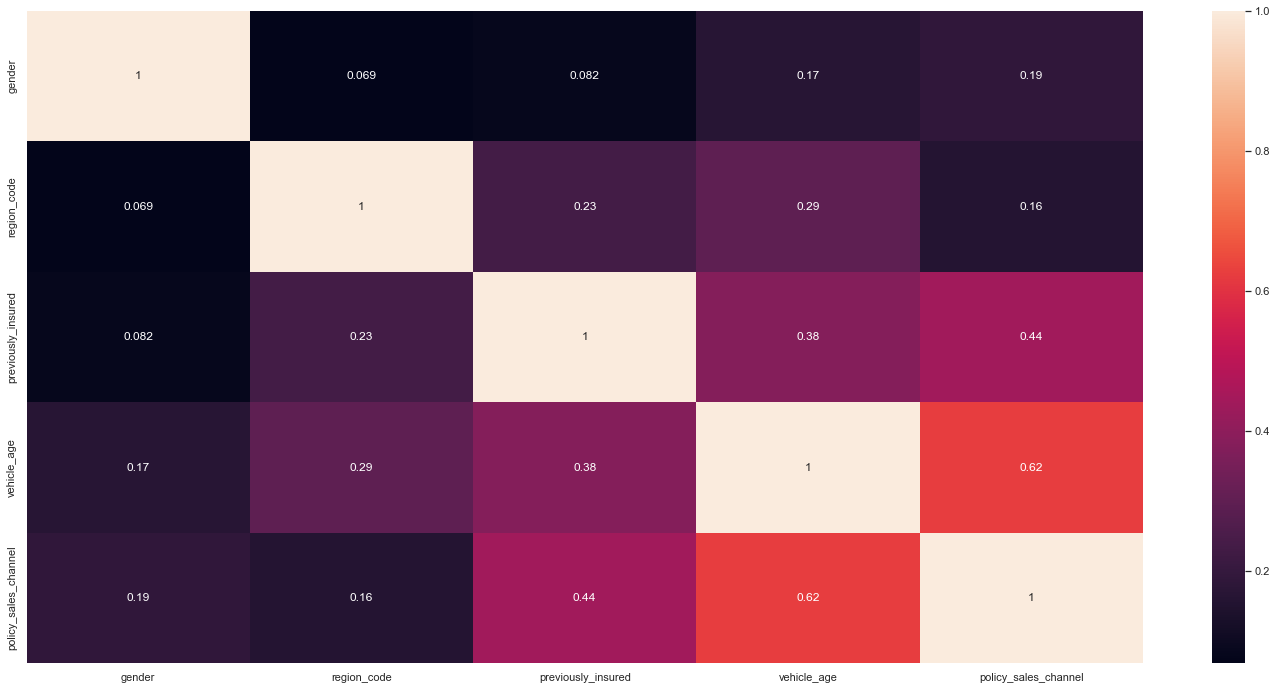

In [54]:
a = df3.select_dtypes(include='object')

# Calculate Cramer V

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['region_code'])
a3 = cramer_v(a['gender'], a['previously_insured'])
a4 = cramer_v(a['gender'], a['vehicle_age'])
a5 = cramer_v(a['gender'], a['policy_sales_channel'])

a6 = cramer_v(a['region_code'], a['gender'])
a7 = cramer_v(a['region_code'], a['region_code'])
a8 = cramer_v(a['region_code'], a['previously_insured'])
a9 = cramer_v(a['region_code'], a['vehicle_age'])
a10 = cramer_v(a['region_code'], a['policy_sales_channel'])

a11 = cramer_v(a['previously_insured'], a['gender'])
a12 = cramer_v(a['previously_insured'], a['region_code'])
a13 = cramer_v(a['previously_insured'], a['previously_insured'])
a14 = cramer_v(a['previously_insured'], a['vehicle_age'])
a15 = cramer_v(a['previously_insured'], a['policy_sales_channel'])

a16 = cramer_v(a['vehicle_age'], a['gender'])
a17 = cramer_v(a['vehicle_age'], a['region_code'])
a18 = cramer_v(a['vehicle_age'], a['previously_insured'])
a19 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a20 = cramer_v(a['vehicle_age'], a['policy_sales_channel'])

a21 = cramer_v(a['policy_sales_channel'], a['gender'])
a22 = cramer_v(a['policy_sales_channel'], a['region_code'])
a23 = cramer_v(a['policy_sales_channel'], a['previously_insured'])
a24 = cramer_v(a['policy_sales_channel'], a['vehicle_age'])
a25 = cramer_v(a['policy_sales_channel'], a['policy_sales_channel'])

# Compose dataset
d = pd.DataFrame({'gender': [a1, a2, a3, a4, a5],
                 'region_code': [a6, a7, a8, a9, a10],
                 'previously_insured': [a11, a12, a13, a14, a15],
                 'vehicle_age': [a16, a17, a18, a19, a20],
                 'policy_sales_channel': [a21, a22, a23, a24, a25]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

### <font color = #990775>DATA PREPARATION</font>

#### <font color = #990775>Split data into training and validation</font>

In [55]:
X = df3.drop('response', axis=1)
y = df3['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df4 = pd.concat([x_train, y_train], axis=1)

In [56]:
df4.shape

(304887, 12)

Many machine learning algorithms perform better whith numerical input variables and also scaled to a standard range: 

#### <font color = #990775>Standardization</font>

In [57]:
# annual premium
ss_annual_premium = pp.StandardScaler()
df4['annual_premium'] = ss_annual_premium.fit_transform(df4[['annual_premium']].values)

#### <font color = #990775>Rescaling</font>

In [58]:
# age
mms_age = pp.MinMaxScaler()
df4['age'] = mms_age.fit_transform(df4[['age']].values)

# vintage
mms_vintage = pp.MinMaxScaler()
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)

#### <font color = #990775>Encoding</font>

In [59]:
# gender - Label Encoding
target_encode_gender = df4.groupby('gender')['response'].mean()
df4['gender'] = df4['gender'].map(target_encode_gender)

# region code - Target Encoding / Frequency Enconding / Weighted Target Encoding
target_encode_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map(target_encode_region_code)

# vehicle age - Label Encoding / One Hot Encoding / Frequency Encoding
df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df4.groupby('policy_sales_channel').size() / len(df4)
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(fe_policy_sales_channel)

#### <font color = #990775>Preparation of the Validation Dataset</font>

In [60]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.fit_transform(x_validation[['age']].values)

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual premium
x_validation.loc[:, 'annual_premium'] = ss_annual_premium.fit_transform(x_validation[['annual_premium']].values)

# policy_sales_channel - Target Encoding / Frequency Encoding
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

### <font color = #990775>FEATURE SELECTION</font>

#### <font color = #990775>Features Importance</font>

In [62]:
# model definition: Extra Trees Classifier as feature selector

forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df4.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

### <font color = #990775>MACHINE LEARNING MODELLING</font>

In [63]:
# Mannually selection of the features that presented more than 5% of importance in the selection above
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df4[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

#### <font color = #990775>K-NN</font>

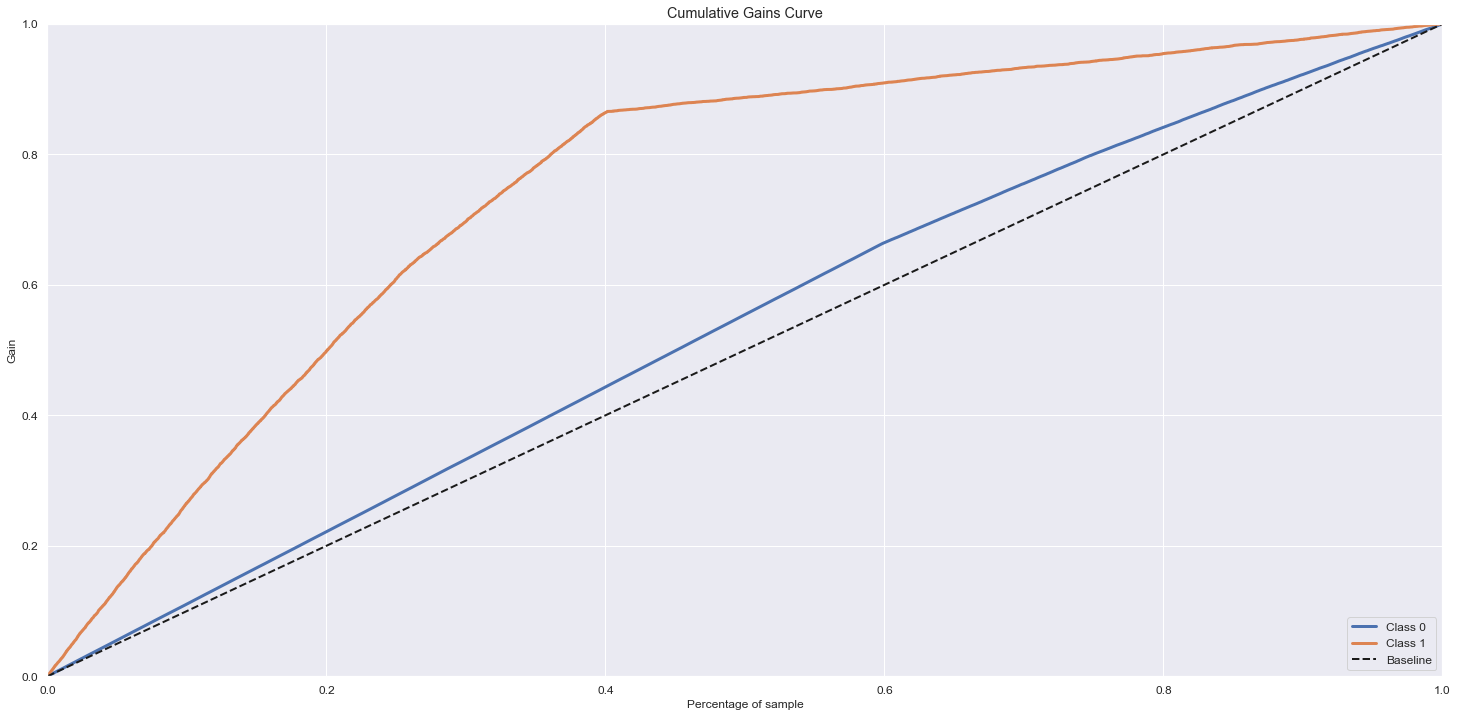

In [64]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - on validation data
yhat_knn = knn_model.predict_proba(x_val)

# Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

#### <font color = #990775>Logistic Regression</font>

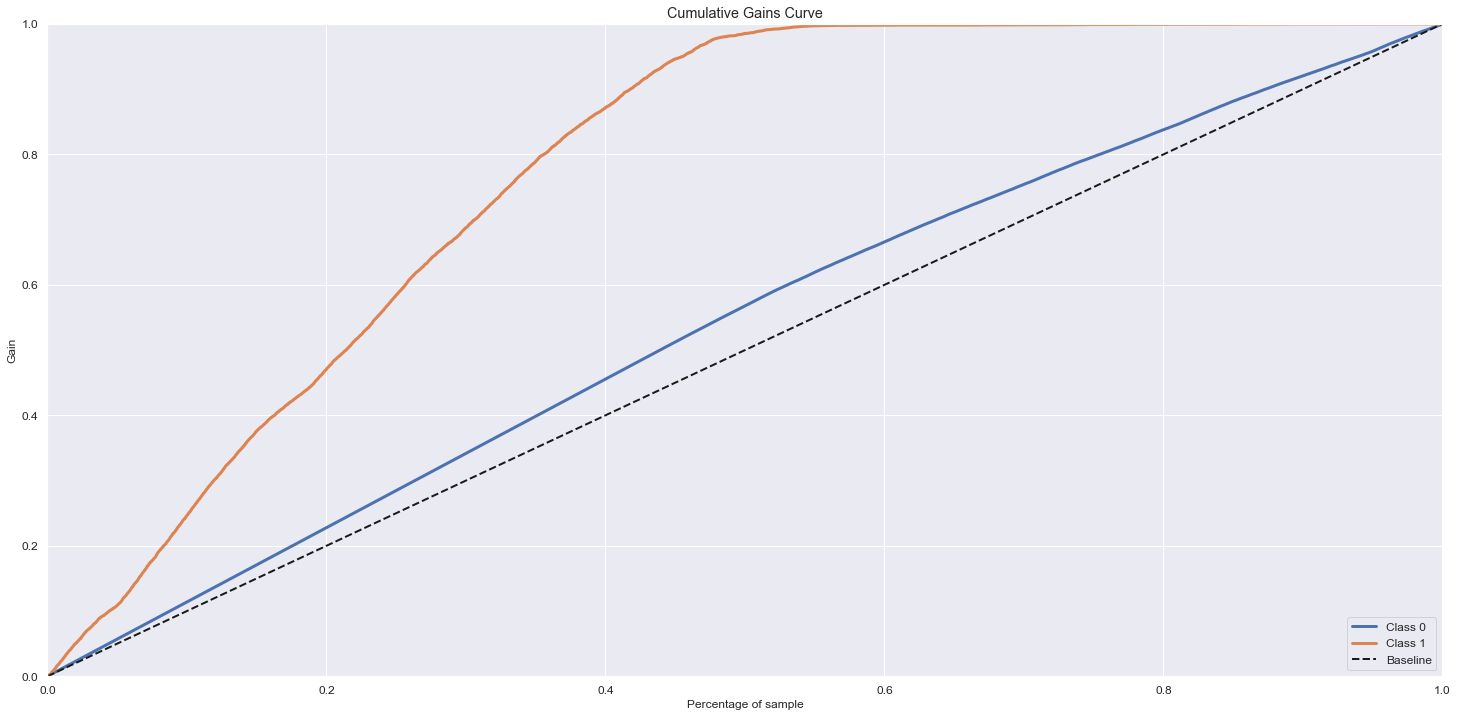

In [65]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction - on validation data
yhat_lr = lr_model.predict_proba(x_val)

# Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

#### <font color = #990775>Extra Trees</font>

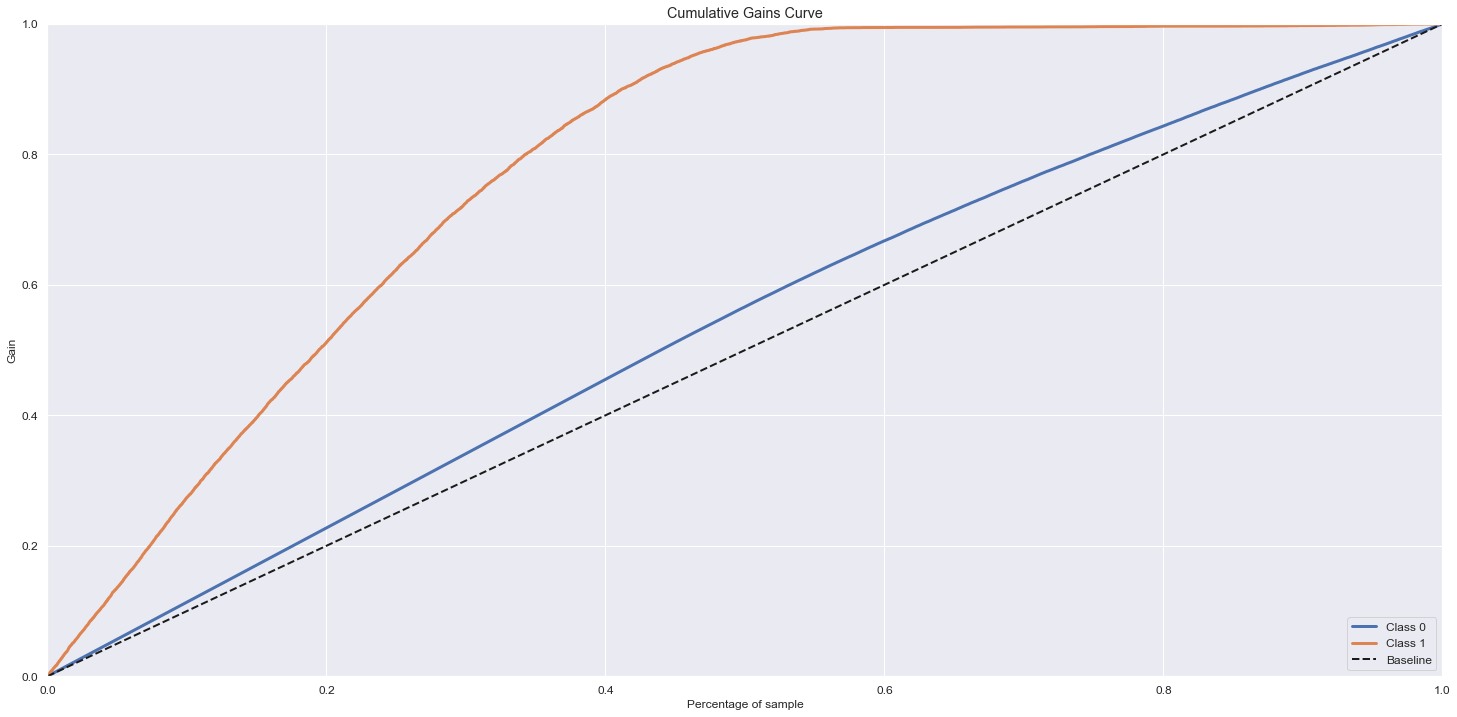

In [66]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=1000, random_state=42)

# model training
et.fit(x_train, y_train)

# model prediction - on validation data
yhat_et = et.predict_proba(x_val)

# Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

#### <font color = #990775>Models' Performance</font>

In [77]:
# copy data
df_per = x_validation.copy()
df_per['response'] = y_validation.copy()

# propensity score
df_per['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df_per = df_per.sort_values('score', ascending=False)

# compute Precision at K
precision_at_20000 = precision_at_k(df_per, k=20000)
precision_at_40000 = precision_at_k(df_per, k=40000)

#compute Recall at K
recall_at_20000 = recall_at_k(df_per, k=20000)
recall_at_40000 = recall_at_k(df_per, k=40000)

print('Precision at k=20000: {}'.format(precision_at_20000))
print('Recall at k=20000: {}'.format(recall_at_20000))

print('Precision at k=40000: {}'.format(precision_at_40000))
print('Recall at k=40000: {}'.format(recall_at_40000))

Precision at k=20000: 0.2953352332383381
Recall at k=20000: 0.6327798607391537
Precision at k=40000: 0.20839479013024675
Recall at k=40000: 0.8929833958221746
